In [2]:
!pip freeze | grep -E "qiskit|pyscf"

pyscf==2.8.0
qiskit==0.44.0
qiskit-aer==0.12.0
qiskit-nature==0.6.2
qiskit-terra==0.25.0


# VQE on Aer Simulator with Noise

In [3]:
import warnings

warnings.filterwarnings("ignore")

### Electronic Structure problem and Qubit Operator

In [4]:
import numpy as np
import pylab
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper

from qiskit_nature.transformers.second_quantization.electronic import (
    ActiveSpaceTransformer,
)
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory

In [5]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]],
    multiplicity=1,
    charge=0,
    units=UnitsType.ANGSTROM,
)

In [6]:
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto-3g", driver_type=ElectronicStructureDriverType.PYSCF
)

properties = driver.run()

In [7]:
num_alpha_electrons = properties.get_property("ParticleNumber").num_alpha
num_beta_electrons = properties.get_property("ParticleNumber").num_beta
num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)

nuclear_rep_energy = properties.get_property(
    "ElectronicEnergy"
).nuclear_repulsion_energy
print("number of alpha electrons: ", num_alpha_electrons)
print("number of beta electrons: ", num_beta_electrons)
print("number of spin orbitals: ", num_spin_orbitals)
print("nuclear repulsion energy: ", nuclear_rep_energy)

number of alpha electrons:  1
number of beta electrons:  1
number of spin orbitals:  4
nuclear repulsion energy:  0.7199689944489797


In [8]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

In [9]:
# Define the active space around the Fermi level
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2,  # Number of electrons in our active space
    num_molecular_orbitals=2,  # Number of orbitals in our active space
    # active_orbitals=[18,19]
)
# Now you can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer])

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [10]:
# Setup the mapper and qubit converter
mapper_type = "ParityMapper"

if mapper_type == "ParityMapper":
    mapper = ParityMapper()
elif mapper_type == "JordanWignerMapper":
    mapper = JordanWignerMapper()
elif mapper_type == "BravyiKitaevMapper":
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
print(qubit_op)

-0.8105479805373274 * IIII
+ 0.17218393261915538 * IIIZ
- 0.22575349222402374 * IIZZ
+ 0.1721839326191554 * IZZI
- 0.22575349222402377 * ZZII
+ 0.12091263261776633 * IIZI
+ 0.16892753870087907 * IZZZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.16614543256382416 * ZZIZ
+ 0.16614543256382416 * IZIZ
+ 0.17464343068300436 * ZZZZ
+ 0.12091263261776633 * ZIZI


In [11]:
# Set the mapper to qubits
parity_mapper = ParityMapper()  # This is the example of parity mapping

# Set the qubit converter with two qubit reduction to reduce the computational cost
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(
    second_q_ops_reduced.get("ElectronicEnergy"),
    num_particles=problem_reduced.num_particles,
)

print(qubit_op_parity)

-1.0523732457728596 * II
+ 0.39793742484317896 * IZ
- 0.39793742484317907 * ZI
- 0.011280104256235102 * ZZ
+ 0.1809311997842313 * XX


### Exact Solution

In [12]:
from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

# solver = GroundStateEigensolver(parity_converter, vqe_factory)  # Define Numpy
solver = GroundStateEigensolver(parity_converter, numpy_solver)
real_solution_t = solver.solve(problem_reduced).total_energies[0]
# real_solution_t = solver.solve(problem_reduced)
print("Reference energy : ", real_solution_t)

Reference energy :  (-1.1373060357534013+0j)


In [13]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_parity)
# print(result)
ref_value = result.eigenvalue.real
print(f"Reference energy: {ref_value:.5f}")

Reference energy: -1.85728


In [14]:
solution = solver.solve(problem_reduced)
active_space_energy = solution.extracted_transformer_energy
print("active_space_energy: ", active_space_energy)

active_space_energy:  0j


### Creating Ansatz

Number of parameters in RY ansatz: 4
Depth of RY ansatz: 5


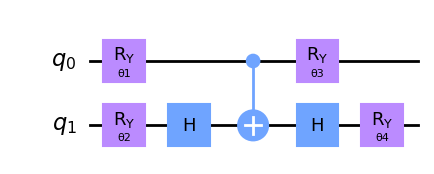

In [15]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta_1, theta_2, theta_3, theta_4 = (
    Parameter("θ1"),
    Parameter("θ2"),
    Parameter("θ3"),
    Parameter("θ4"),
)
ansatz = QuantumCircuit(2)
ansatz.ry(theta_1, 0)
ansatz.ry(theta_2, 1)
ansatz.h(1)
ansatz.cx(0, 1)
ansatz.h(1)
ansatz.ry(theta_3, 0)
ansatz.ry(theta_4, 1)
print("Number of parameters in RY ansatz:", len(ansatz.parameters))
print("Depth of RY ansatz:", ansatz.depth())
ansatz.draw("mpl")

Number of parameters in UCC ansatz: 3
Depth of UCC ansatz: 4


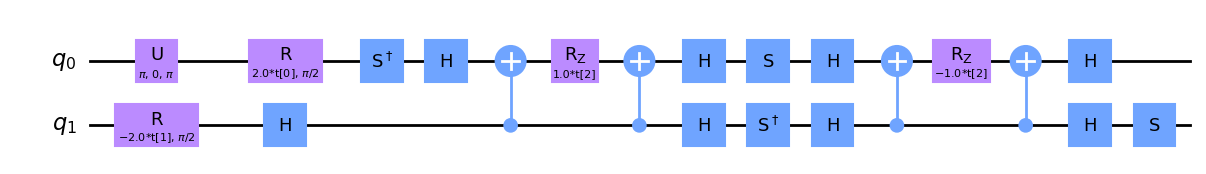

In [16]:
from qiskit_nature.circuit.library import HartreeFock, UCC

init_state = HartreeFock(
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    num_particles=problem_reduced.num_particles,
    qubit_converter=parity_converter,
)

ansatz_ucc = UCC(
    qubit_converter=parity_converter,
    num_particles=problem_reduced.num_particles,
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    excitations="sd",
    initial_state=init_state,
)
print("Number of parameters in UCC ansatz:", len(ansatz_ucc.parameters))
print("Depth of UCC ansatz:", ansatz_ucc.decompose().depth())
ansatz_ucc.decompose(reps=3).draw("mpl")

## Performance without noise

In [17]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

In [18]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend("aer_simulator")
qi = QuantumInstance(
    backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=100000
)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


ansatz = ansatz_ucc
# ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(
    ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi
)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.85599
Delta from reference energy value is 0.00128


Text(0.5, 1.0, 'Convergence with no noise')

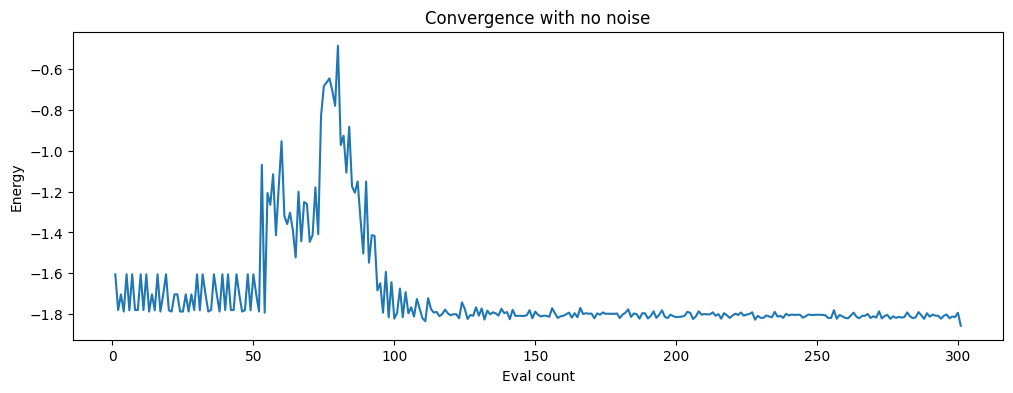

In [19]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

## Performance with noise

Here we will create a noise model for Aer from an actual device.

First we need to get an actual device backend and from its `configuration` and `properties` we can setup a coupling map and a noise model to match the device.

Note: simulation with noise will take longer than without noise.

Terra Mock Backends:

We will use real noise data for an IBM Quantum device using the date stored in Qiskit Terra. Specifically, in this tutorial, the device is ibmq_vigo.

In [20]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo

device_backend = FakeVigo()

backend = Aer.get_backend("aer_simulator")
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(
    backend=backend,
    seed_simulator=seed,
    seed_transpiler=seed,
    coupling_map=coupling_map,
    noise_model=noise_model,
)


def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)


# var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(
    ansatz_ucc, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi
)
result1 = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}"
)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'sx', 'x']
  Instructions with noise: ['measure', 'cx', 'x', 'id', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]

VQE on Aer qasm simulator (with noise): -1.73521
Del

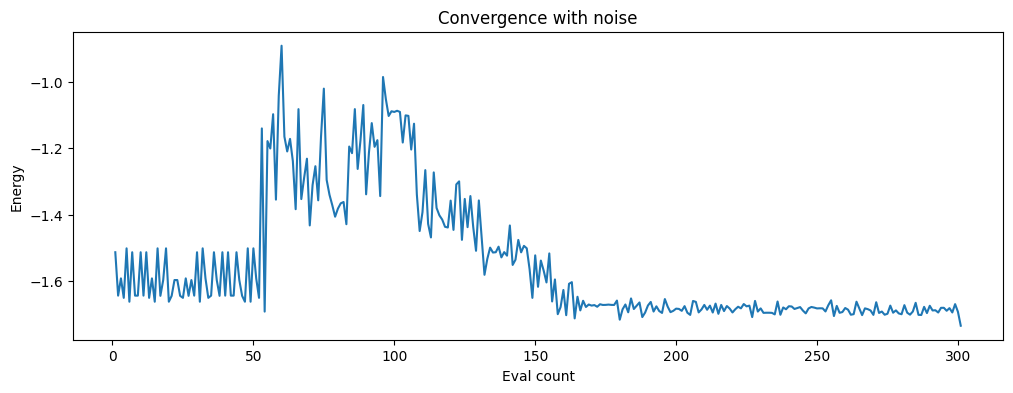

In [21]:
if counts1 or values1:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts1, values1)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

## Performance *with* noise and measurement error mitigation

Now we will add method for measurement error mitigation, which increases the fidelity of measurement. Here we choose `CompleteMeasFitter` to mitigate the measurement error. The calibration matrix will be auto-refresh every 30 minute (default value).

In [22]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(
        backend=backend,
        seed_simulator=seed,
        seed_transpiler=seed,
        coupling_map=coupling_map,
        noise_model=noise_model,
        measurement_error_mitigation_cls=CompleteMeasFitter,
        cals_matrix_refresh_period=30,
    )

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    # ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(
        ansatz_ucc,
        optimizer=spsa,
        callback=store_intermediate_result2,
        quantum_instance=qi,
    )
    result2 = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
    print(
        f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}"
    )
    print(
        f"Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}"
    )

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.78444
Delta from reference energy value is 0.07283


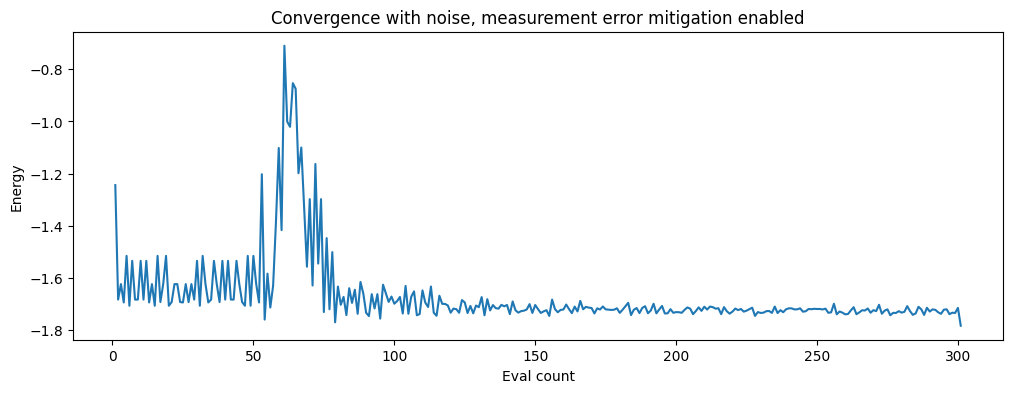

In [23]:
if counts2 or values2:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts2, values2)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise, measurement error mitigation enabled")

In [24]:
print(f"Reference value: {ref_value:.5f}")
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(
    f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}"
)

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.85599
VQE on Aer qasm simulator (with noise): -1.73521
VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.78444


In [25]:
dev_no_noise = result.eigenvalue.real - ref_value
dev_with_noise = result1.eigenvalue.real - ref_value
dev_with_noise_mem = result2.eigenvalue.real - ref_value

Text(0.5, 1.0, 'Deviation from exact solution')

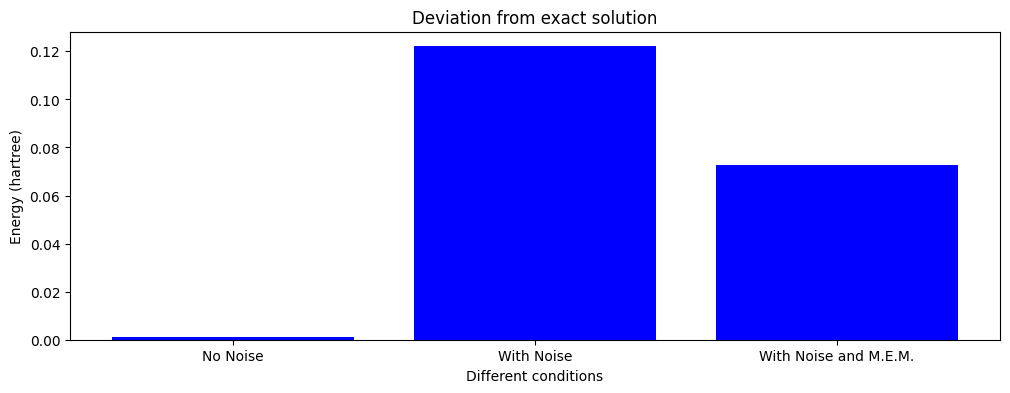

In [26]:
import matplotlib.pyplot as plt

deviation = [abs(dev_no_noise), abs(dev_with_noise), abs(dev_with_noise_mem)]
x_labels = ["No Noise", "With Noise", "With Noise and M.E.M."]

plt.bar(x_labels, deviation, color="blue")
plt.xlabel("Different conditions")
plt.ylabel("Energy (hartree)")
plt.title("Deviation from exact solution")

In [27]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(
        backend=backend,
        seed_simulator=seed,
        seed_transpiler=seed,
        coupling_map=coupling_map,
        noise_model=noise_model,
        measurement_error_mitigation_cls=CompleteMeasFitter,
        cals_matrix_refresh_period=30,
    )

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(
        ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi
    )
    result3 = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
    print(
        f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}"
    )
    print(
        f"Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}"
    )

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.78444
Delta from reference energy value is 0.07283


In [28]:
dev_ucc = result2.eigenvalue.real - ref_value
dev_tl = result3.eigenvalue.real - ref_value

Text(0.5, 1.0, 'Deviation from exact solution')

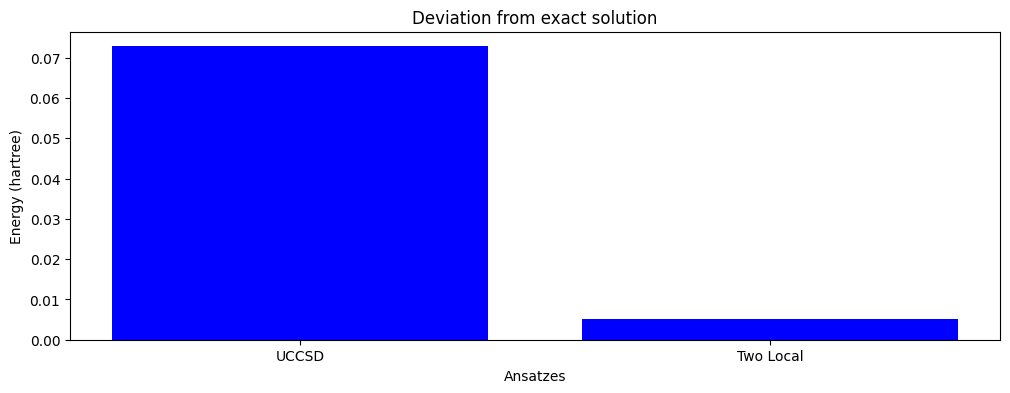

In [29]:
import matplotlib.pyplot as plt

deviation = [abs(dev_ucc), abs(dev_tl)]
x_labels = ["UCCSD", "Two Local"]

plt.bar(x_labels, deviation, color="blue")
plt.xlabel("Ansatzes")
plt.ylabel("Energy (hartree)")
plt.title("Deviation from exact solution")